In [769]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import heapq
from collections import defaultdict, Counter
import struct
import sys
from scipy import fftpack
from bitarray import bitarray
import math
import os

# Funções úteis

In [770]:
""" def calcEntropy(image):
    hist = cv2.calcHist([image],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    print("prob ", hist)
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()
    return entropy
 """
def calculate_entropy(matrix):
    number_of_elements = matrix.shape[0] * matrix.shape[1]
    occurence_dict = dict(Counter(matrix.flatten()))
    entropy = 0
    for key in occurence_dict:
        probability = occurence_dict[key] / number_of_elements
        entropy -= probability * np.log2(probability)
    return entropy

def plot_histogram(matrix):
    # Flatten the matrix to a 1D array
    flattened_matrix = matrix.flatten()
    
    # Plot the histogram
    plt.hist(flattened_matrix, bins=range(int(flattened_matrix.min()), int(flattened_matrix.max()) + 2), edgecolor='black', align='left')
    
    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Value Occurrences in Matrix')
    
    # Show the plot
    plt.show()

""" def divideImageIntoSubImages(image, subImageSize):
    subImages = []
    for i in range(0, image.shape[0], subImageSize):
        for j in range(0, image.shape[1], subImageSize):
            subImages.append(image[i:i+subImageSize, j:j+subImageSize])
    return np.array(subImages)

def reconstructImage(subimages, originalImageShape):
    image = np.zeros(originalImageShape)
    idx = 0
    for i in range(0, originalImageShape[0], subimages[0].shape[0]):
        for j in range(0, originalImageShape[1], subimages[0].shape[1]):
            image[i:i+subimages[0].shape[0], j:j+subimages[0].shape[1]] = subimages[idx]
            idx += 1
    return image """

def get_number_of_different_colors(img):
    return len(np.unique(img))

def plot_image(img, title):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

def add_padding(img, block_size):
    rows, cols = img.shape
    paddedImg = np.zeros((rows + block_size - rows % block_size, cols + block_size - cols % block_size))
    paddedImg[:rows, :cols] = img
    return paddedImg

def remove_padding(img, original_shape):
    return img[:original_shape[0], :original_shape[1]]

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

# Leitura da Imagem

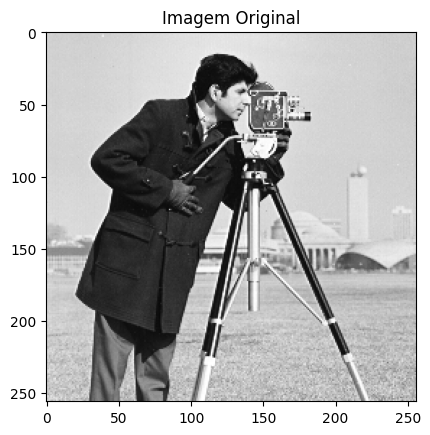

In [771]:
IMAGE_NAME = 'cameraman'
ORIGINAL_IMAGE = cv2.imread(f'./imagens/{IMAGE_NAME}.pgm',0)
ORIGINAL_IMAGE_SHAPE = ORIGINAL_IMAGE.shape
plot_image(ORIGINAL_IMAGE, 'Imagem Original')

In [772]:
""" ORIGINAL_IMAGE = add_padding(ORIGINAL_IMAGE, 8)
plot_image(ORIGINAL_IMAGE, 'Imagem com padding')
ORIGINAL_IMAGE_SHAPE = ORIGINAL_IMAGE.shape """

" ORIGINAL_IMAGE = add_padding(ORIGINAL_IMAGE, 8)\nplot_image(ORIGINAL_IMAGE, 'Imagem com padding')\nORIGINAL_IMAGE_SHAPE = ORIGINAL_IMAGE.shape "

In [773]:
type(ORIGINAL_IMAGE[0][0])

numpy.uint8

In [774]:
m = ORIGINAL_IMAGE# np.array([[1,2,3],[4,5,6],[7,8,9]]).astype(np.uint8)
print(calculate_entropy(m))

6.904608517841746


In [ ]:
BLOCK_SIZE = 8

# Tirar os residuos/  Pegar os resíduos e transformar na imagem original - Giovana 

In [776]:
def generate_macroblocks(img, block_size):
    """
    Generates macroblocks of a given size from the image.
    """
    for y in range(0, img.shape[0], block_size):
        for x in range(0, img.shape[1], block_size):
            macroblock = img[y:y+block_size, x:x+block_size]
            yield y, x, macroblock

def get_vertical_prediction(macroblock,left_column = None):
    """
    Applies a predictive function without loss on each macro block based on
    the formula f(x, y) = f(x, y) - f(x, y - 1).
    """
    new_block = np.zeros_like(macroblock, dtype=float)
    if left_column is not None:
        new_block[:,:] = left_column
    else: 
        new_block[:,0] = 0
        new_block[:,1:] = macroblock[:,0].reshape(-1, 1) 
    # print(new_block,left_column)
    # new_block[:,:] = macroblock[:,0:]
    return new_block

def get_horizontal_prediction(macroblock, top_row=None):
    """
    Applies a vertical predictive function on a given macroblock based on the formula
    f(x, y) = f(x, y) - f(x-1, y). 
    """
    new_block = np.zeros_like(macroblock, dtype=float)
    if top_row is not None:
        new_block[:,:] = top_row.reshape(-1, 1) 
    else: 
        new_block[0,:] = 0
        new_block[1:,:] = macroblock[0,:].reshape(1, -1) 
    
    # new_block[1:,:] = macroblock[0:-1,:]
    
    return new_block

def get_mean_prediction(macroblock,left_column,top_row):

    block_size = macroblock.shape[0]
    new_block = np.zeros_like(macroblock, dtype=float)

    if left_column is not None and top_row is not None:
        mean_value = int((np.sum(top_row) + np.sum(left_column)) / (2 * block_size))
        new_block = np.full((block_size, block_size), mean_value)

    return new_block

def calculate_entropy(block):
    """
    Calculates the entropy of the given block.
    """
    # Flatten the block and calculate the probability distribution
    if(type(block) == list):
        flattened_block = sum(block, [])
    else:
        flattened_block = block.flatten()
    value_counts = Counter(flattened_block)
    
    # Calculate the probabilities of each unique value
    total_count = sum(value_counts.values())
    probabilities = np.array([count / total_count for count in value_counts.values()])
    
    # Calculate entropy
    return -np.sum(probabilities * np.log2(probabilities))

def get_best_prediction(original_block,block_vertical, block_horizontal,block_mean):
    """
    Compares two blocks by calculating their entropy and returns the block
    with the lowest entropy along with an indicator of which block was chosen.
    """
    # Calculate entropy for both blocks
    entropy_vertical = calculate_entropy(block_vertical)
    entropy_horizontal = calculate_entropy(block_horizontal)
    entropy_mean = calculate_entropy(block_mean)
    
    # Find the block with the minimum entropy
    entropies = [entropy_vertical, entropy_horizontal, entropy_mean]
    blocks = [block_vertical, block_horizontal, block_mean]
    min_entropy_index = entropies.index(min(entropies))
    
    # Return the block with the lowest entropy and its index
    return blocks[min_entropy_index],min_entropy_index
    
def process_image(img, block_size):
    """
    Processes the entire image by dividing it into macroblocks,
    applying the predictive function to each block, and 
    reconstructing the output image.
    """
    options = []  # To store the choice of predictive function (0 or 1)
    pred_img = np.zeros_like(img, dtype=float)
    
    # Iterate over each macroblock in the image
    for y, x, macroblock in generate_macroblocks(img, block_size):
        # Get left column and top row from the last macroblock for prediction
        left_column = img[y:y+block_size,x-1] if (x > 0) else None
        top_row = img[y-1, x:x+block_size] if (y > 0) else None

        block_vertical   = macroblock - get_vertical_prediction(macroblock,left_column) 
        block_horizontal = macroblock - get_horizontal_prediction(macroblock,top_row)
        block_mean = macroblock - get_mean_prediction(macroblock,left_column,top_row)



        # Select the best prediction based on entropy
        new_block, option = get_best_prediction(macroblock,block_vertical, block_horizontal,block_mean) ## testar remover e calcular a entropia
        options.append(option)

        # Place the processed block back into the image
        pred_img[y:y+block_size, x:x+block_size] = new_block

    return pred_img, options

def reconstruct_image(residual_img, block_size, pred_type):
    """
    Reconstructs the original image from a residual image.
    """
    # Create an empty array to store the reconstructed original image
    original_img = np.zeros_like(residual_img, dtype=float)

    i = 0
    # Iterate over the image in blocks of size `block_size`
    for y, x, residual_block in generate_macroblocks(residual_img, block_size):
        left_column = original_img[y:y+block_size,x-1] if (x > 0) else None
        top_row = original_img[y-1, x:x+block_size] if (y > 0) else None

        reconstructed_block = np.zeros_like(residual_block, dtype=float)
        
        # Extract the current residual block
        if pred_type[i] == 0:
            reconstructed_block = get_vertical_prediction(residual_block, left_column)
            
        
        elif pred_type[i] == 1:
            reconstructed_block = get_horizontal_prediction(residual_block, top_row)

        elif pred_type[i] == 2:
            reconstructed_block = get_mean_prediction(residual_block,left_column, top_row)
        
        # Place the reconstructed block back into the image
        original_img[y:y+block_size, x:x+block_size] = reconstructed_block + residual_block

        i+=1

    return original_img

    

# Zig Zag

In [777]:
SYMBOL_EOB = 2**15 - 1
print(SYMBOL_EOB)
def zigzag_encode(matrix):
    """
    Encodes a 2D matrix into a 1D array using zig-zag traversal.
    """
    rows, cols = matrix.shape
    result = []
    for s in range(rows + cols - 1):
        if s % 2 == 0:  # Even diagonals go "up"
            for i in range(s + 1):
                j = s - i
                if i < rows and j < cols:
                    result.append(matrix[i, j])
        else:  # Odd diagonals go "down"
            for i in range(s + 1):
                j = s - i
                if j < rows and i < cols:
                    result.append(matrix[j, i])
    return result

def zigzag_decode(encoded, block_size):
    """
    Decodes a 1D array into a 2D matrix using zig-zag traversal.
    """
    rows,cols = block_size,block_size
    matrix = np.zeros((rows, cols), dtype=int)
    index = 0
    for s in range(rows + cols - 1):
        if s % 2 == 0:  # Even diagonals go "up"
            for i in range(s + 1):
                j = s - i
                if i < rows and j < cols:
                    matrix[i, j] = encoded[index]
                    index += 1
        else:  # Odd diagonals go "down"
            for i in range(s + 1):
                j = s - i
                if j < rows and i < cols:
                    matrix[j, i] = encoded[index]
                    index += 1
    return matrix

def apply_zigzag_image(image, block_size):

    zigzag_code = []

    for _, _, residual_block in generate_macroblocks(image, block_size):
        zigzag_code.append(zigzag_encode(residual_block))
    
    return np.array(zigzag_code)

def apply_zigzag_decode(zigzags, block_size, image_shape):
    decoded = np.zeros(image_shape)
    index_zigzag = 0
    for y, x, block in generate_macroblocks(decoded, block_size):
        decoded[y:y+block_size, x:x+block_size] = zigzag_decode(zigzags[index_zigzag], block_size)
        index_zigzag += 1
    
    return decoded

def run_length_encode(data):
    """
    Encodes a list using Run-Length Encoding (RLE).
    """

    encoded = []
    count = 1
    for i in range(1, len(data)):
        if data[i] == data[i - 1]:
            count += 1
        else:
            encoded.append((data[i - 1], count))
            count = 1
    # Append the last element
    encoded.append((data[-1], count))
    return encoded

def apply_run_length_zigzags(zigzags):
    rle_code = []

    for zigzag in zigzags:
        rle_code.append(run_length_encode(zigzag))
    return rle_code

def run_length_decode(encoded):
    """
    Decodes a Run-Length Encoded (RLE) list.
    """
    decoded = []
    for value, count in encoded:
        decoded.extend([value] * count)
    return decoded

def zigzag_to_eob(zigzag_array):
    rle = []
    # Iterate over the zigzag array
    for i in range(len(zigzag_array)):
        if zigzag_array[i] != 0:
            rle.append(zigzag_array[i])
        else:
            # Check if all remaining zigzag_array[i]s are zero
            if all(v == 0 for v in zigzag_array[i:]):
                rle.append(SYMBOL_EOB)
                break
            else:
                rle.append(0)        
    return rle

def eob_to_zigzag(eob_array):
    zigzag = []
    for i in range(len(eob_array)):
        if eob_array[i] != SYMBOL_EOB:
            zigzag.append(eob_array[i])
        else:
            zigzag.extend([0] * (BLOCK_SIZE * BLOCK_SIZE - i))
            break
    return zigzag

def apply_zigzag_to_eob(image,block_size):
    zigzag_code = []

    for _, _, residual_block in generate_macroblocks(image, block_size):
        zigzag_code.append(zigzag_to_eob(zigzag_encode(residual_block)))
    
    return zigzag_code

def apply_eob_to_zigzag(zigzags):
    zigzag_code = []
    for zigzag in zigzags:
        zigzag_code.append(eob_to_zigzag(zigzag))
    
    return np.array(zigzag_code)



32767


# Fazer a tranformada/fazer a transformada inversa - Fernando


In [778]:
QUANTIZATION_MATRIX = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]]) / 5

def get_dct(img):
    ''' 
    Get 2D Cosine Transform of Image
    '''
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_idct(coefficients):
    ''' 
    Get 2D Inverse Cosine Transform of Image
    '''
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def apply_image_transformation(img, block_size, transform_function):
    '''
    Apply block-wise DCT or IDCT to an image.
    '''
    size = img.shape
    transformed_img = np.zeros(size, dtype=float)

    for y, x, macroblock in generate_macroblocks(img, block_size):
        transformed_img[y:y+block_size, x:x+block_size] = transform_function(macroblock)
        

    return transformed_img

def apply_quantization(transformed_image,block_size):

    size = transformed_image.shape
    quantized_image = np.zeros(size, dtype=float)
    
    for y, x, macroblock in generate_macroblocks(transformed_image, block_size):
        quantized_block = np.divide(macroblock, QUANTIZATION_MATRIX)
        quantized_block = np.round(quantized_block)
        quantized_image[y:y+block_size, x:x+block_size] = quantized_block
    return quantized_image.astype(int)

def apply_dequantization(transformed_image,block_size):

    size = transformed_image.shape
    dequantized_image = np.zeros(size, dtype=float)

    for y, x, macroblock in generate_macroblocks(transformed_image, block_size):
        dequantized_block = np.multiply(macroblock, QUANTIZATION_MATRIX)
        dequantized_image[y:y+block_size, x:x+block_size] = dequantized_block

    return dequantized_image


# Uso

In [779]:
block_size = 8
img = ORIGINAL_IMAGE.astype(np.float64) - 128

residuals, PREDICTIONS_OPTIONS = process_image(img, block_size)
transformed_residuals = apply_image_transformation(residuals, block_size, get_dct)
quantized_residuals = apply_quantization(transformed_residuals,block_size)
zigzag_quantized_residuals = apply_zigzag_image(quantized_residuals,block_size)
zigzag_quantized_residuals_with_eob = apply_zigzag_to_eob(quantized_residuals,block_size)
print(quantized_residuals.shape)
print(zigzag_quantized_residuals.shape)
rle_encoded_residuals = apply_run_length_zigzags(zigzag_quantized_residuals)
last_elements = zigzag_quantized_residuals[:, -1]

# print("Last elements in each row:", sum(last_elements))
#print(zigzag_encoded_residuals_with_eob)
# print(f"Entropia sem rle e sem eob: {calculate_entropy(np.array(zigzag_encoded_residuals))}")
# print(f"Entropia com eob: {calculate_entropy(zigzag_encoded_residuals_with_eob)}")
# print(f"Entropia com rle: {calculate_entropy(rle_encoded_residuals)}")

(256, 256)
(1024, 64)


In [780]:
_quantized_residuals = apply_zigzag_decode(zigzag_quantized_residuals, BLOCK_SIZE, ORIGINAL_IMAGE_SHAPE)
print(_quantized_residuals.shape)
_dequantized_residuals = apply_dequantization(_quantized_residuals,block_size)
residuals_ = apply_image_transformation(_dequantized_residuals, block_size, get_idct)
reconstructed_image = reconstruct_image(residuals_, block_size, PREDICTIONS_OPTIONS)
reconstructed_image = reconstructed_image.astype(np.float64) + 128
plot_image(reconstructed_image, 'Imagem Reconstruída')
print(f"RMSE : {rmse(reconstructed_image, ORIGINAL_IMAGE)}")
print(f"PSNR : {psnr(reconstructed_image, ORIGINAL_IMAGE)}")

IndexError: index 1024 is out of bounds for axis 0 with size 1024

# Codificar/Decodidicar (huffman) - Araju


In [ ]:
class Node:
    def __init__(self, freq, symbol=None, left=None, right=None):
        self.freq = freq
        self.symbol = symbol
        self.left = left
        self.right = right

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(frequencies):
    heap = [Node(freq, symbol) for symbol, freq in frequencies.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(left.freq + right.freq, left=left, right=right)
        heapq.heappush(heap, merged)

    return heap[0] if heap else None

def generate_huffman_codes(node, prefix="", codebook=None):
    if codebook is None:
        codebook = {}

    if node is not None:
        if node.symbol is not None:
            codebook[node.symbol] = prefix
        generate_huffman_codes(node.left, prefix + "0", codebook)
        generate_huffman_codes(node.right, prefix + "1", codebook)

    return codebook


# Salvar no arquivo a imagem comprimida/ descomprimir a imagem -  Araju


In [ ]:
def encode_data(data, huffman_codes):
    return ''.join(huffman_codes[symbol] for symbol in data)

def decode_data(encoded_data, huffman_codes):
    reverse_huffman_codes = {v: k for k, v in huffman_codes.items()}
    current_code = ""
    decoded_data = []

    for bit in encoded_data:
        current_code += bit
        if current_code in reverse_huffman_codes:
            decoded_data.append(reverse_huffman_codes[current_code])
            current_code = ""

    return decoded_data


def save_to_file(original_image_shape, filename, huffman_codes, encoded_data, predictions_options):
    with open(filename, 'wb') as file:

        # Save the shape of the original image
        file.write(struct.pack('<I', original_image_shape[0]))
        file.write(struct.pack('<I', original_image_shape[1]))
        
        # Create a bitarray for predictions options
        bits = bitarray(endian='big')
        
        # Convert each prediction to a 2-bit binary representation
        for value in predictions_options:
            if value < 0 or value > 3:
                raise ValueError("Predictions must be between 1 and 3")
            bits.extend(format(value, '02b'))
        
        # Write the bitarray to the file
        bits.tofile(file)
        
        # Save the number of unique symbols
        file.write(struct.pack('<I', len(huffman_codes)))

        # Save the Huffman codes
        for symbol, code in huffman_codes.items():
            file.write(struct.pack('<i', symbol))  # Symbol as 4 bytes
            file.write(struct.pack('<B', len(code)))  # Length of the code
            file.write(code.encode())  # Code as bytes

        # Save the length of the encoded data in bits
        file.write(struct.pack('<I', len(encoded_data)))
        # Convert the encoded data to bytes
        buffer = 0
        buffer_length = 0
        byte_array = bytearray()

        for bit in encoded_data:
            buffer = (buffer << 1) | int(bit)
            buffer_length += 1

            if buffer_length == 8:
                byte_array.append(buffer)
                buffer = 0
                buffer_length = 0

        if buffer_length > 0:
            buffer <<= (8 - buffer_length)
            byte_array.append(buffer)
        file.write(byte_array)

def load_from_file(filename):
    with open(filename, 'rb') as file:
        # Read the shape of the original image
        original_image_shape = (struct.unpack('<I', file.read(4))[0], struct.unpack('<I', file.read(4))[0])
        
        number_of_blocks = math.ceil(original_image_shape[0] * original_image_shape[1] / (BLOCK_SIZE * BLOCK_SIZE))
       
        # Calculate the number of bits needed for the predictions
        num_bits = number_of_blocks * 2
        
        # Read the necessary number of bytes for the predictions
        num_bytes = (num_bits + 7) // 8  # Round up to ensure we read enough bytes
        bits = bitarray(endian='big')
        bits.fromfile(file, num_bytes)
        
        # Convert the bitarray back to predictions options
        predictions_options = []
        for i in range(number_of_blocks):
            # Get each 2-bit segment
            two_bits = bits[i*2:i*2+2].to01()
            # Convert binary string to integer back to [0, 3]
            value = int(two_bits, 2)
            predictions_options.append(value)
        
        print(f" PREDICTIONS_OPTIONS == predictions_options: {PREDICTIONS_OPTIONS == predictions_options}")
        # Read the number of unique symbols
        num_symbols = struct.unpack('<I', file.read(4))[0]

        # Read the Huffman codes
        huffman_codes = {}
        for _ in range(num_symbols):
            symbol = struct.unpack('<i', file.read(4))[0]
            code_length = struct.unpack('<B', file.read(1))[0]
            code = file.read(code_length).decode()
            huffman_codes[symbol] = code

        # Read the length of the encoded data in bits
        encoded_data_length = struct.unpack('<I', file.read(4))[0]

        # Read the encoded data as bits
        encoded_data = ''
        while len(encoded_data) < encoded_data_length:
            byte = file.read(1)
            if not byte:
                break
            byte_value = ord(byte)
            encoded_data += f'{byte_value:08b}'

        return original_image_shape, huffman_codes, encoded_data[:encoded_data_length], predictions_options

def huffman_encode_matrix(matrix):
    flat_list = [item for sublist in matrix for item in sublist]
    frequencies = Counter(flat_list)
    huffman_tree = build_huffman_tree(frequencies)
    huffman_codes = generate_huffman_codes(huffman_tree)
    encoded_data = encode_data(flat_list, huffman_codes)
    return huffman_codes, encoded_data

def huffman_decode_matrix(encoded_data, huffman_codes):
    decoded_flat_list = decode_data(encoded_data, huffman_codes)
    zigzag_encoded_residuals_with_eob = []
    curr_zig_zag = []
    for el in decoded_flat_list:
        curr_zig_zag.append(el)
        if el == SYMBOL_EOB or len(curr_zig_zag) == BLOCK_SIZE * BLOCK_SIZE:
            zigzag_encoded_residuals_with_eob.append(curr_zig_zag)
            curr_zig_zag = []
    return zigzag_encoded_residuals_with_eob



In [ ]:
# tamanho original da imagem
# opcao de predicao por macrobloco
# dicionario de huffman

In [ ]:
# print(f"Entropia sem rle e sem eob: {calculate_entropy(np.array(zigzag_encoded_residuals))}")
# print(f"Entropia com eob: {calculate_entropy(zigzag_encoded_residuals_with_eob)}")
# print(f"Entropia com rle: {calculate_entropy(rle_encoded_residuals)}")

In [ ]:
#zigzag_encoded_residuals

In [ ]:
#zigzag_encoded_residuals_with_eob

In [ ]:
#rle_encoded_residuals

In [ ]:
#huffman_encode_matrix(zigzag_encoded_residuals_with_eob)

In [ ]:
def lists_equal(list1, list2):
    if len(list1) != len(list2):
        return False
    for sublist1, sublist2 in zip(list1, list2):
        if sublist1 != sublist2:
            return False
    return True



In [ ]:
# Random Matrix 8 x 8
matrix_to_save = zigzag_quantized_residuals_with_eob#np.random.randint(-300, 300, (8, 8))
image_shape = ORIGINAL_IMAGE_SHAPE
huffman_codes, encoded_data = huffman_encode_matrix(matrix_to_save)
COMPRESSED_IMAGE_NAME = f'{IMAGE_NAME}_compressed.gfa'
save_to_file(image_shape, COMPRESSED_IMAGE_NAME, huffman_codes, encoded_data, PREDICTIONS_OPTIONS)

loaded_orginal_image_shape, loaded_huffman_codes, loaded_encoded_data, loaded_predictions_options = load_from_file(COMPRESSED_IMAGE_NAME)

decoded_matrix = huffman_decode_matrix(loaded_encoded_data, loaded_huffman_codes)
print(f"shape: {image_shape} == {loaded_orginal_image_shape} : {image_shape == loaded_orginal_image_shape}")
print(f"predictions_options: PREDICTIONS_OPTIONS == loaded_predictions_options : {PREDICTIONS_OPTIONS == loaded_predictions_options}")
print(f"matrix: matrix_to_save == decoded_matrix : {lists_equal(matrix_to_save, decoded_matrix)}")


 PREDICTIONS_OPTIONS == predictions_options: True
shape: (488, 504) == (488, 504) : True
predictions_options: PREDICTIONS_OPTIONS == loaded_predictions_options : True
matrix: matrix_to_save == decoded_matrix : True


# Descompressão

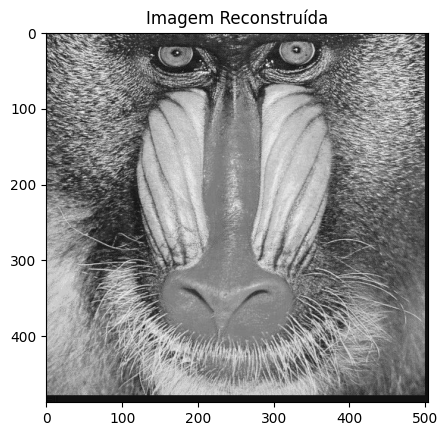

RMSE : 3.9212888169184845
PSNR : 36.2622269923377
Taxa de compressão: 2.0057656633855308


In [ ]:
_zigzag_encoded_residuals_with_eob = decoded_matrix
_zig_zags = apply_eob_to_zigzag(_zigzag_encoded_residuals_with_eob)
_quantized_residuals = apply_zigzag_decode(_zig_zags, BLOCK_SIZE, ORIGINAL_IMAGE_SHAPE)
_dequantized_residuals = apply_dequantization(_quantized_residuals, BLOCK_SIZE)
_residuals_ = apply_image_transformation(_dequantized_residuals, BLOCK_SIZE, get_idct)
_reconstructed_image = reconstruct_image(_residuals_, BLOCK_SIZE, loaded_predictions_options)
_reconstructed_image = _reconstructed_image.astype(np.float64) + 128
plot_image(_reconstructed_image, 'Imagem Reconstruída')
print(f"RMSE : {rmse(_reconstructed_image, ORIGINAL_IMAGE)}")
print(f"PSNR : {psnr(_reconstructed_image, ORIGINAL_IMAGE)}")
size_compressd = os.path.getsize(f"./{COMPRESSED_IMAGE_NAME}")
size_original = os.path.getsize(f"./imagens/{IMAGE_NAME}.pgm")
print(f"Taxa de compressão: {size_original/size_compressd}")